# Housekeeping

## Library imports

In [26]:
#TODO: use %store mydf and %store -r mydf (and also del in the first notebook) to divide the processes in the separate notebooks

if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

In [27]:
# Core Libraries
import pandas as pd
import seaborn as sns
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import re
import os

# Machine Learning - Core
import sklearn
#import tensorflow as tf

# Statistical & Data Processing
from scipy import stats
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model Interpretability
from sklearn.metrics import mean_squared_error, r2_score
from supertree import SuperTree

#Features selection
import shap

# Custom Functions
from functions import (
    random_forest_benchmark,
    xgboost_benchmark,
    adaboost_benchmark,
    gradient_boosting_benchmark,
    lightgbm_benchmark,
#    nn_feature_search,
    explain_with_lime,
    explain_with_shap,
    cross_validate_feature_cutoffs,
    plot_feature_cutoff_comparison,
    plot_model_comparison_heatmap,
    plot_residuals_analysis,
    plot_prediction_intervals,
    plot_learning_curves,
    feature_selection_pipeline,
    final_battle,
    set_global_seeds,
    get_taxonomic_level,
    filter_features_by_level,
    stochastic_gradient_boosting_benchmark,
    kernel_random_forest_benchmark,
    compare_feature_selection_methods,
    find_best_evaluation_metric,
    clr_transform
)

#Importing Master Seed 3004
from functions import MASTER_SEED

## Optional Imports (for specific analyses)

These imports are used for specific visualizations and analyses that may not be needed in every run.

In [28]:
# Optional: Advanced Visualizations
import collections  # Built-in, no install needed

# Note: Most visualization functions are now in functions.py
# and imported above in the main imports cell

## Settings

In [29]:
warnings.filterwarnings("ignore")
sklearn.set_config(transform_output="pandas")
print(Style.RESET_ALL)

'''gpus = tf.config.list_physical_devices('GPU')
if gpus or False: #<- Change to True if you want to torture your computer (:
    RUN_NN = True
    print("GPU found")
else:
    RUN_NN = False'''

'gpus = tf.config.list_physical_devices(\'GPU\')\nif gpus or False: #<- Change to True if you want to torture your computer (:\n    RUN_NN = True\n    print("GPU found")\nelse:\n    RUN_NN = False'

In [30]:
# Set global random seeds for reproducibility
set_global_seeds(MASTER_SEED)

Global seeds set to 3004


## Data imports
Data was manually edited, to convert the mpa411.txt TSV format to a CSV format. Otherwise, Pandas was loading it as a single column, somehow. The first row, containing only "#mpa_vJun23_CHOCOPhlAnSGB_202403" was removed.

In [31]:
data = pd.read_csv('../data/raw/MAI3004_lucki_mpa411.csv')
metadata = pd.read_csv('../data/raw/MAI3004_lucki_metadata_safe.csv')
print(
    f"Data successfully imported. \n shape of data: {data.shape} \n "
    f"Shape of metadata: {metadata.shape}"
)

assert data.shape == (6903, 932), "Data has the wrong shape. Check the CSV formatting."
assert metadata.shape == (930, 6), "Metadata has the wrong shape. Check the CSV formatting."

Data successfully imported. 
 shape of data: (6903, 932) 
 Shape of metadata: (930, 6)


# Data preprocessing

## Merge data and metadata

In [32]:
sample_cols = [col for col in data.columns if col.startswith("mpa411_")]

sample_abundances = (
    data[['clade_name'] + sample_cols]
    .set_index('clade_name')
    .transpose()
    .rename_axis('original_sample_id')
    .reset_index()
    .rename(columns={'original_sample_id': 'sample_id'})
)

sample_abundances["sample_id"] = (
    sample_abundances["sample_id"].str.removeprefix(
        "mpa411_",
    )
)

metadata_common = metadata[
    metadata["sample_id"].isin(sample_abundances["sample_id"])
].copy()
merged_samples = metadata_common.merge(
    sample_abundances,
    on="sample_id",
    how="inner",
)

merged_samples.drop(columns=['year_of_birth', 'body_product'], inplace=True)

print(f"Metadata rows (original): {metadata.shape[0]}")
print(f"Metadata rows with matching samples: {metadata_common.shape[0]}")
print(
    f"Metadata rows without matching samples: "
    f"{metadata_common.shape[0]-metadata_common.shape[0]}"
)
print(f"Merged dataframe shape: {merged_samples.shape}")

Metadata rows (original): 930
Metadata rows with matching samples: 930
Metadata rows without matching samples: 0
Merged dataframe shape: (930, 6907)


In [33]:
merged_samples.head()

,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Encoding

In [34]:
# Sex and family_ID
encoded_samples = merged_samples.copy().dropna(subset="age_group_at_sample")

encoded_samples["sex"] = (
    encoded_samples["sex"]
    .fillna("unknown")
    .replace({"female": 1, "male": 0, "unknown": 2})
)
encoded_samples["family_id"] = LabelEncoder().fit_transform(
    encoded_samples["family_id"]
)


In [35]:
#Using days to better interpret the distance between age groups
encoding_guide = {
    '1-2 weeks': 10,
    '4 weeks': 28,
    '8 weeks': 56,
    '4 months': 120,
    '5 months': 150,
    '6 months': 180,
    '9 months': 270,
    '11 months': 330,
    '14 months': 420,
}
encoded_samples["age_group_at_sample"] = encoded_samples["age_group_at_sample"].replace(encoding_guide)
encoded_samples["age_group_at_sample"] = encoded_samples["age_group_at_sample"].astype(int)
# consider in interpretation that the distances between the real age bins are not the same as our age groups

In [36]:
leftovers = encoded_samples[encoded_samples["age_group_at_sample"].apply(lambda x: isinstance(x, str))]

if not leftovers.empty:

    print("Age group encoding:", leftovers["age_group_at_sample"].unique())

else:
    print("Fallback encoding not needed")


Fallback encoding not needed


## Missing check

In [37]:
missing_table = (
    encoded_samples.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(
        missing_percent=lambda df: (
            (df["missing_count"] / encoded_samples.shape[0] * 100).round(2)
        ),
    )
    .reset_index()
    .rename(columns={"index": "column"})
    .sort_values("missing_count", ascending=False)
    .query("missing_count != 0")
)

if len(missing_table) > 0:
    missing_table
else:
    print("No missing values detected.")

No missing values detected.


## Outlier check

In [38]:
numeric_cols = encoded_samples.select_dtypes(include=[np.number]).columns

q1 = encoded_samples[numeric_cols].quantile(0.25)
q3 = encoded_samples[numeric_cols].quantile(0.75)
iqr = q3 - q1

lower_bounds = q1 - 1.5 * iqr
upper_bounds = q3 + 1.5 * iqr

outlier_mask = (
    (encoded_samples[numeric_cols] < lower_bounds)
    | (encoded_samples[numeric_cols] > upper_bounds)
)
outlier_counts = outlier_mask.sum()
outlier_percent = (outlier_counts / encoded_samples.shape[0] * 100).round(2)

outlier_table = (
    pd.DataFrame({
        "column": numeric_cols,
        "lower_bound": lower_bounds,
        "upper_bound": upper_bounds,
        "outlier_count": outlier_counts,
        "outlier_percent": outlier_percent,
    })
    .query("outlier_count > 0")
    .sort_values("outlier_percent", ascending=False)
    .reset_index(drop=True)
)

outlier_table

,column,lower_bound,upper_bound,outlier_count,outlier_percent
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,201,24.88
1,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0.000000,0.000000,201,24.88
2,k__Bacteria|p__Verrucomicrobia,-0.000195,0.000325,200,24.75
3,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,0.000000,0.000000,198,24.50
4,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,0.000000,0.000000,198,24.50
...,...,...,...,...,...
5155,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0.000000,0.000000,1,0.12
5156,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,0.000000,0.000000,1,0.12
5157,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,1,0.12
5158,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0.000000,0.000000,1,0.12


## Normalisation check

In [39]:
normalized_samples = encoded_samples.copy()
print("Shapiro-Wilk Normality Test")

for column in numeric_cols:
    data_nona = normalized_samples[column].dropna()
    stat, p_value = stats.shapiro(data_nona)

    if p_value > 0.05:
        print(Fore.GREEN + f"{column}: Normally Distributed (p={p_value:.4f})")

    else:
        print(
            Fore.RED
            + f"{column}: Not Normally Distributed (p={p_value:.4f})"
        )

print(Style.RESET_ALL)

Shapiro-Wilk Normality Test
family_id: Not Normally Distributed (p=0.0000)
sex: Not Normally Distributed (p=0.0000)
age_group_at_sample: Not Normally Distributed (p=0.0000)
UNCLASSIFIED: Not Normally Distributed (p=0.0000)
k__Bacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Candidatus_Saccharibacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Bacteroidota: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria|c__Actinomycetia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Negativicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Clostridia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Bacilli: Not Normally Dist

## Train-test split before pre-processing

In [40]:
feature_cols = normalized_samples.columns.difference(["sample_id", "age_group_at_sample"]) # These variables will get removed from X

X = normalized_samples[feature_cols]
Y = normalized_samples["age_group_at_sample"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=MASTER_SEED)
train_indicies, test_indicies = next(gss.split(X, Y, groups=X['family_id']))
X_train_raw = X.iloc[train_indicies]
X_test_raw = X.iloc[test_indicies]
Y_train = Y.iloc[train_indicies]
Y_test = Y.iloc[test_indicies]

assert X_train_raw.shape[1] == X_test_raw.shape[1], "Feature columns do not match between train and test sets."
assert X_train_raw.shape[0] == Y_train.shape[0] and X_test_raw.shape[0] == Y_test.shape[0], "X and Y do not have the same length."

print("Train shape:", X_train_raw.shape, "| Test shape:", X_test_raw.shape)

Train shape: (628, 6905) | Test shape: (180, 6905)


## Normalising data using clr transformation

In [41]:
X_train = clr_transform(X_train_raw)
X_test = clr_transform(X_test_raw)

In [42]:
# To activate back the raw data without normalisation, uncomment the following:
# X_train = X_train_raw
# X_test = X_test_raw

In [43]:
print("Shapiro-Wilk Normality Test (after Log Normalisation)\n")

for col in X_train.columns:

    # 1. Get the data for this column from both sets
    train_data = X_train[col].dropna()
    test_data = X_test[col].dropna()

    # 2. Run Shapiro test on both
    stat_train, p_train = stats.shapiro(train_data)
    stat_test, p_test = stats.shapiro(test_data)

    # 3. Determine status (Both must be > 0.05 to be truly "Normal")
    is_train_normal = p_train > 0.05
    is_test_normal = p_test > 0.05

    # 4. Print Logic
    # If both are Green
    if is_train_normal and is_test_normal:
        print(Fore.GREEN + f"✔ {col}: Normal (Train p={p_train:.3f}, Test p={p_test:.3f})")

    # If one is Red (Mixed results)
    elif is_train_normal or is_test_normal:
        print(Fore.YELLOW + f"⚠ {col}: Inconsistent (Train p={p_train:.3f}, Test p={p_test:.3f})")

    # If both are Red
    else:
        print(Fore.RED + f"✘ {col}: Not Normal (Train p={p_train:.3f}, Test p={p_test:.3f})")

print(Style.RESET_ALL)

Shapiro-Wilk Normality Test (after Log Normalisation)

✘ UNCLASSIFIED: Not Normal (Train p=0.000, Test p=0.000)
✘ family_id: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Candidatus_Methanomethylophilaceae: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Candidatus_Methanomethylophilaceae|g__Candidatus_Methanomethylophilus: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicocca

# Exploratory data analysis

In [44]:
print(merged_samples.shape)
merged_samples.head()

(930, 6907)


,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Dataset overview
print("Number of samples:", len(merged_samples))
print(
    "Number of unique families (family_id):",
    merged_samples["family_id"].nunique(),
)
print("Number of columns (metadata + features):", merged_samples.shape[1])

Number of samples: 930
Number of unique families (family_id): 139
Number of columns (metadata + features): 6907


In [46]:
# Samples per family
samples_per_family = merged_samples["family_id"].value_counts()
samples_per_family.describe()

count    139.000000
mean       6.690647
std        2.232335
min        1.000000
25%        5.500000
50%        7.000000
75%        8.000000
max       11.000000
Name: count, dtype: float64

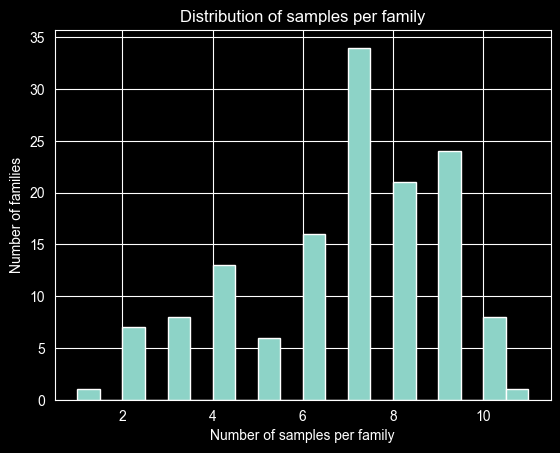

In [47]:
samples_per_family.hist(bins=20)
plt.xlabel("Number of samples per family")
plt.ylabel("Number of families")
plt.title("Distribution of samples per family")
plt.show()

In [48]:
#distribution of age groups
merged_samples["age_group_at_sample"].value_counts(dropna=False)

age_group_at_sample
NaN          122
8 weeks      105
4 months     103
5 months      96
9 months      92
6 months      88
1-2 weeks     84
11 months     83
4 weeks       82
14 months     75
Name: count, dtype: int64

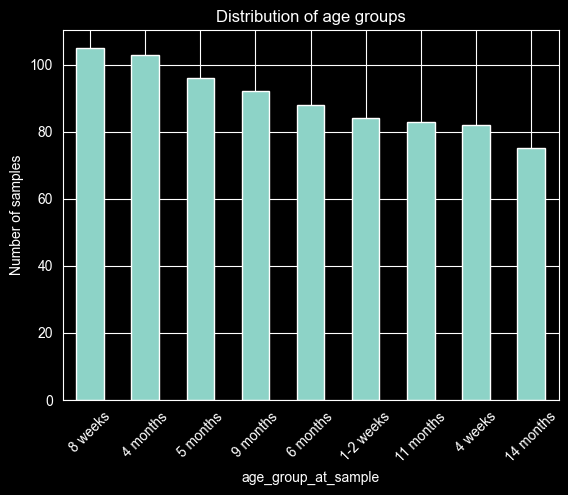

In [49]:
merged_samples["age_group_at_sample"].value_counts().plot(kind="bar")
plt.title("Distribution of age groups")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.show()

In [50]:
#dimensionality and sparsity of the microbiome feature matrix
metadata_cols = [
    "sample_id",
    "family_id",
    "sex",
    "body_product",
    "age_group_at_sample",
    "year_of_birth",
]
feature_cols = [c for c in merged_samples.columns if c not in metadata_cols]

X = merged_samples[feature_cols]

print("Feature matrix shape:", X.shape)
print("Overall fraction of zeros:", (X == 0).mean().mean())

Feature matrix shape: (930, 6903)
Overall fraction of zeros: 0.9556136571445484


In [51]:
#number of observed taxa per sample
nonzero_per_sample = (X > 0).sum(axis=1)
nonzero_per_sample.describe()

count     930.000000
mean      306.398925
std       338.629879
min        46.000000
25%       127.000000
50%       181.000000
75%       282.000000
max      1821.000000
dtype: float64

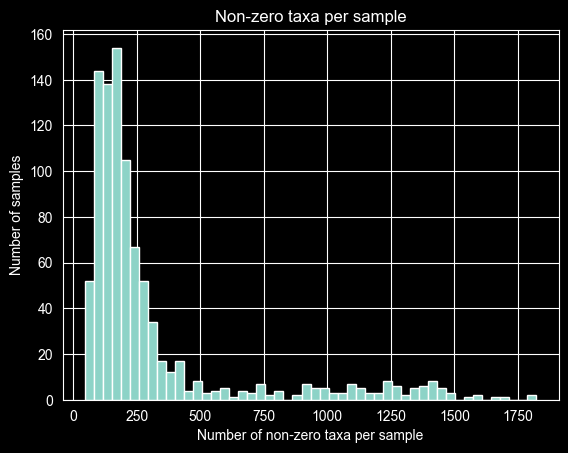

In [52]:
nonzero_per_sample.hist(bins=50)
plt.xlabel("Number of non-zero taxa per sample")
plt.ylabel("Number of samples")
plt.title("Non-zero taxa per sample")
plt.show()

In [53]:
# Total abundance per sample (sanity check)
total_abundance = X.sum(axis=1)
total_abundance.describe()

count    930.000000
mean     704.546050
std       64.838116
min      337.616534
25%      676.683539
50%      715.251764
75%      749.225950
max      800.000170
dtype: float64

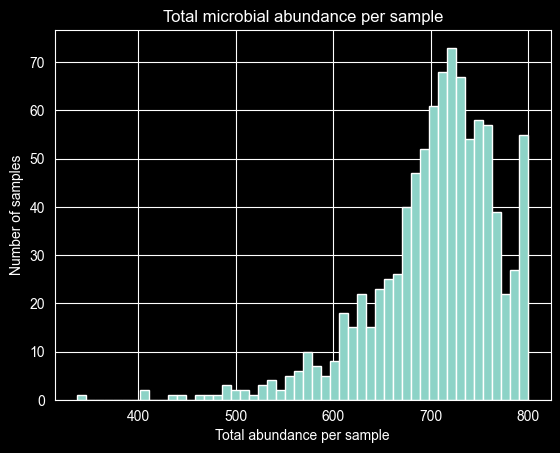

In [54]:
total_abundance.hist(bins=50)
plt.xlabel("Total abundance per sample")
plt.ylabel("Number of samples")
plt.title("Total microbial abundance per sample")
plt.show()

In [55]:
# Distribution of feature prevalence
feature_prevalence = (X > 0).sum(axis=0)
feature_prevalence.describe()

count    6903.000000
mean       41.279299
std        96.983595
min         1.000000
25%         2.000000
50%         9.000000
75%        38.000000
max       930.000000
dtype: float64

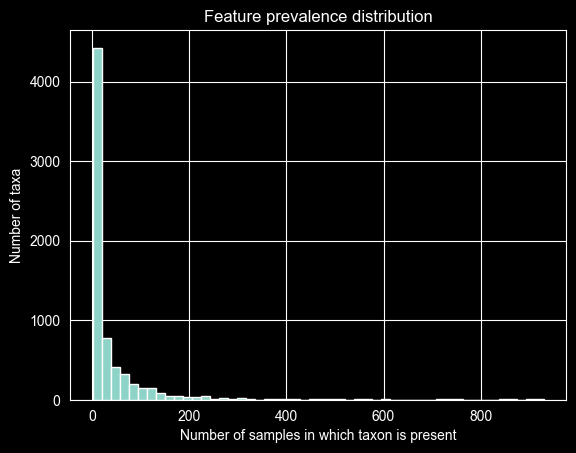

In [56]:
feature_prevalence.hist(bins=50)
plt.xlabel("Number of samples in which taxon is present")
plt.ylabel("Number of taxa")
plt.title("Feature prevalence distribution")
plt.show()

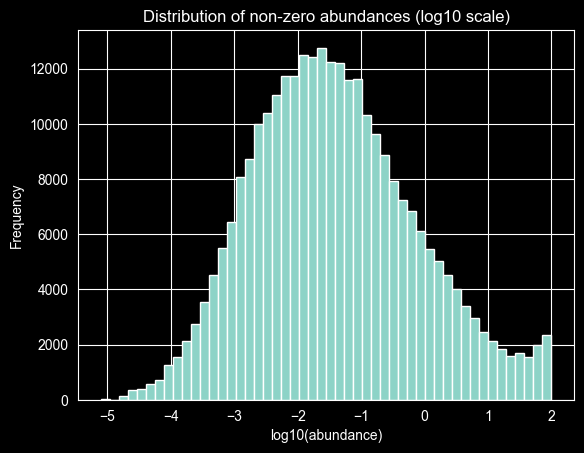

In [57]:
# Distribution of non-zero abundances (log scale)

nonzero_values = X.values[X.values > 0]
plt.hist(np.log10(nonzero_values), bins=50)
plt.xlabel("log10(abundance)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero abundances (log10 scale)")
plt.show()

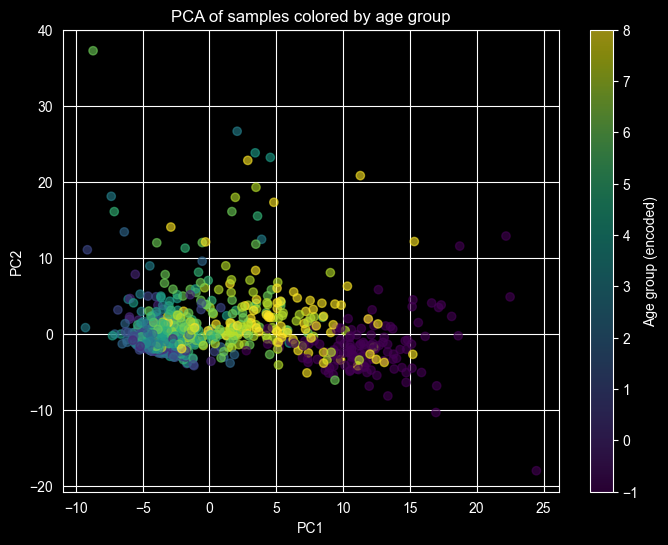

Explained variance ratio: [0.07115835 0.02969284]


In [58]:
# PCA visualization
# Use a subset of features for speed
prevalence = (X > 0).sum(axis=0)
top_features = prevalence.sort_values(ascending=False).head(500).index

X_sub = X[top_features]

# Scale features
X_scaled = StandardScaler().fit_transform(X_sub)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
age = merged_samples["age_group_at_sample"]

plt.figure(figsize=(8,6))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1],
            c=pd.factorize(age)[0], cmap="viridis", alpha=0.6)
plt.colorbar(label="Age group (encoded)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of samples colored by age group")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.14151387 0.05000885] | Cumulative: 0.19152271407902074
PC1 range: -10.831594743921125 25.46619242418319
PC2 range: -19.700949502896197 13.339079432726539


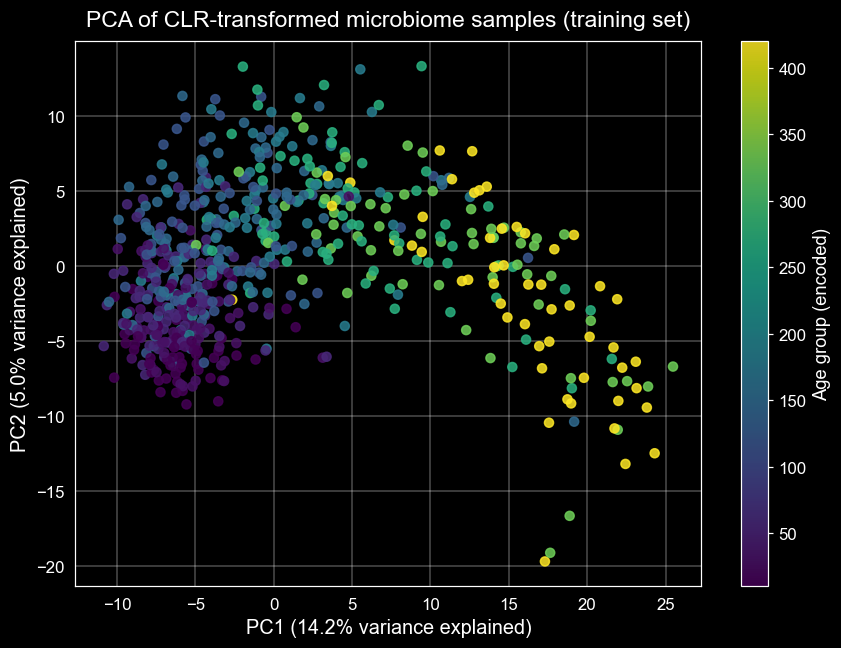

In [59]:
# PCA on CLR-transformed data (training set)

# Use only microbiome features (exclude metadata)
meta_cols = [c for c in ["sex", "family_id"] if c in X_train.columns]
micro_cols = [c for c in X_train.columns if c not in meta_cols]

Xtr = X_train[micro_cols].copy()
Xte = X_test[micro_cols].copy()

# Optional: select top N most prevalent taxa (for speed)
top_n = 500
if top_n is not None:
    prevalence = (Xtr > 0).sum(axis=0)
    top_features = prevalence.sort_values(ascending=False).head(top_n).index
    Xtr = Xtr[top_features]
    Xte = Xte[top_features]

# Convert to NumPy
Xtr_np = Xtr.to_numpy()
Xte_np = Xte.to_numpy()

# Scale
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr_np)
Xte_scaled = scaler.transform(Xte_np)


# PCA
pca = PCA(n_components=2, random_state=3004)
Ztr = pca.fit_transform(Xtr_scaled)
Zte = pca.transform(Xte_scaled)

# Force NumPy output again
Ztr = np.asarray(Ztr)
Zte = np.asarray(Zte)

print("Explained variance ratio:", pca.explained_variance_ratio_, "| Cumulative:", pca.explained_variance_ratio_.sum())
print("PC1 range:", Ztr[:, 0].min(), Ztr[:, 0].max())
print("PC2 range:", Ztr[:, 1].min(), Ztr[:, 1].max())

# Plot (high readability)
plt.style.use("dark_background")

plt.figure(figsize=(8, 6), dpi=110)

sc = plt.scatter(
    Ztr[:, 0],
    Ztr[:, 1],
    c=Y_train.values,
    s=35,
    cmap="viridis",
    alpha=0.85
)

cbar = plt.colorbar(sc)
cbar.set_label("Age group (encoded)", fontsize=12)
cbar.ax.tick_params(labelsize=11)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance explained)", fontsize=13)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance explained)", fontsize=13)
plt.title("PCA of CLR-transformed microbiome samples (training set)", fontsize=15, pad=10)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, color="white", alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()


### Summary of EDA
The dataset consists of 930 stool samples derived from multiple individuals across different families and contains approximately 6,900 microbiome features, making it a high-dimensional and highly sparse dataset. Each sample contains on average around 300 detected taxa, while the total microbial abundance per sample is relatively stable, indicating that sequencing depth is relatively consistent across samples.

Most taxa are rare and occur in only a small fraction of samples, whereas a small subset of taxa is highly prevalent across the cohort. The distribution of non-zero abundances follows an approximately log-normal shape, which is typical for microbiome sequencing data (Lutz et al., 2022).

An initial PCA projection based on the most prevalent taxa and raw abundance data does not reveal sharply separated clusters but shows a gradual age-related gradient, suggesting that age-related variation in microbiome composition is present but represents only a limited fraction of the total variance in the data.

Because microbiome data are compositional in nature, a second PCA is later performed on CLR-transformed and standardized data in the preprocessing stage to obtain a compositionally valid low-dimensional representation for downstream analysis and modeling.


# Model Training

## Filtering for features at the genus level

In [65]:
X_train_genus_raw = filter_features_by_level(X_train, max_level="Genus")
X_train_genus, _ = feature_selection_pipeline(X_train_genus_raw)
X_test_genus = X_test[X_train_genus.columns]

TypeError: feature_selection_pipeline() missing 1 required positional argument: 'Y_train'

### Alternative: Using Taxonomic Level Functions

Demonstrate filtering by different taxonomic levels using helper functions.

In [62]:
#TODO: Do the filtering, and only after the CLR transformation
# Example: Get taxonomic level of a feature
sample_feature = X_train.columns[0]
tax_level = get_taxonomic_level(sample_feature)
print(f"Feature: {sample_feature}")
print(f"Taxonomic level: {tax_level}")

# Filter features by different taxonomic levels
print(f"\nOriginal features: {X_train.shape[1]}")

X_train_family_raw = filter_features_by_level(X_train, max_level="Family")
X_train_family, _ = feature_selection_pipeline(X_train_family_raw)
X_test_family = X_test[X_train_family.columns]
print(f"Family-level features: {X_train_family.shape[1]}")

X_train_order_raw = filter_features_by_level(X_train, max_level="Order")
X_train_order, _ = feature_selection_pipeline(X_train_family_raw)
X_test_order = X_test[X_train_order.columns]
print(f"Order-level features: {X_train_order.shape[1]}")

X_train_species_raw = filter_features_by_level(X_train, max_level="Species")
X_train_species, _ = feature_selection_pipeline(X_train_species_raw)
X_test_species = X_test[X_train_species.columns]
print(f"Species-level features: {X_train_species.shape[1]}")

X_train_phylum_raw = filter_features_by_level(X_train, max_level="Phylum")
X_train_phylum, _ = feature_selection_pipeline(X_train_phylum_raw)
X_test_phylum = X_test[X_train_phylum.columns]
print(f"Phylum-level features: {X_train_species.shape[1]}")

X_train_class_raw = filter_features_by_level(X_train, max_level="Class")
X_train_class, _ = feature_selection_pipeline(X_train_class_raw)
X_test_class = X_test[X_train_class.columns]
print(f"Phylum-level features: {X_train_species.shape[1]}")

Feature: UNCLASSIFIED
Taxonomic level: Unknown

Original features: 6905


TypeError: feature_selection_pipeline() missing 1 required positional argument: 'Y_train'

In [63]:
print(f"Genus Level: {X_train_genus.shape[1]} features | Family Level: {X_train_family.shape[1]} features | Order Level: {X_train_order.shape[1]} features | Species Level: {X_train_species.shape[1]}")

NameError: name 'X_train_genus' is not defined

In [ ]:
print("Features used by model:")
print(X_train_genus.columns.tolist())

In [ ]:
# Initialize model results tracking
model_results = []
print("Model results tracking initialized")

## Random Forest Regressor with Train/Test split (Genus)

In [ ]:
# Default starting parameters
current_params = {
    "prevalence_thresh": 0.05,
    "abundance_thresh": 1e-4,
    "variance_thresh": 1e-5,
    "corr_thresh": 0.9
}

# Maximum perturbation for each parameter
param_ranges = {
    "prevalence_thresh": 0.01,
    "abundance_thresh": 5e-5,
    "variance_thresh": 5e-6,
    "corr_thresh": 0.05
}

best_rmse = np.inf
best_r2 = -np.inf
results = []

n_iterations = 50  # you can increase this for a more thorough search

for i in range(n_iterations):
    # Random perturbation for all parameters
    new_params = {
        k: max(1e-9, current_params[k] + np.random.uniform(-param_ranges[k], param_ranges[k]))
        for k in current_params
    }
    # Keep corr_thresh <= 0.99
    if new_params["corr_thresh"] >= 1.0:
        new_params["corr_thresh"] = 0.99

    # Apply feature filtering
    X_train_filtered, removed_features = feature_selection_pipeline(
        X_train_genus_raw,
        prevalence_thresh=new_params["prevalence_thresh"],
        abundance_thresh=new_params["abundance_thresh"],
        variance_thresh=new_params["variance_thresh"],
        corr_thresh=new_params["corr_thresh"]
    )
    X_test_filtered = X_test[X_train_filtered.columns]

    # Train a quick model
    rf_temp = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train_filtered, Y_train)
    preds = rf_temp.predict(X_test_filtered)

    rmse = np.sqrt(mean_squared_error(Y_test, preds))
    r2 = r2_score(Y_test, preds)

    results.append({
        **new_params,
        "rmse": rmse,
        "r2": r2,
        "n_features": X_train_filtered.shape[1]
    })

    # Keep new params if performance improved
    if rmse < best_rmse:
        best_rmse = rmse
        best_r2 = r2
        current_params = new_params.copy()

    if (i+1) % 10 == 0:
        print(f"Iteration {i+1}: Best RMSE = {best_rmse:.2f}, Best R² = {best_r2:.3f}")

# Save all results for review
results_df = pd.DataFrame(results)
print("\nBest parameters found:")
print(current_params)
print(f"\nBest RMSE: {best_rmse:.2f}")
print(f"Best R²: {best_r2:.3f}")

## Random Forest Regressor with Train/Test split (Genus)

### Base model

In [ ]:
# Base model
rf_base = RandomForestRegressor(
    random_state=MASTER_SEED,
    n_jobs=-1,
    oob_score=True
)

rf_base.fit(X_train_genus, Y_train)
yhat_rf = rf_base.predict(X_test_genus)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_rf):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_rf)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_rf):.3f}")


### Search for the best model

In [ ]:
rf_results = random_forest_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {rf_results.best_params}")

In [ ]:
# Track Random Forest results
model_results.append({
    'model': 'Random Forest',
    'rmse': rf_results.rmse,
    'r2': rf_results.r2,
    'best_params': rf_results.best_params,
})

In [ ]:
print(f"Mean Squared Error: {rf_results.rmse**2:.3f}") # Squared because rmse is sqrt(mse)
print(f"Best CV RMSE: {rf_results.rmse:.3f}")
print(f"R2 Score: {rf_results.r2:.3f}")

best_rf_model = rf_results.model
yhat = rf_results.model.predict(X_test_genus)

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

In [ ]:
residuals = Y_test - yhat

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

In [ ]:
importances = pd.Series(
    best_rf_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()

In [ ]:
st = SuperTree(
    best_rf_model,
    X_train_genus,
    Y_train
)

st.show_tree(which_tree=0)

In [ ]:
# get predictions from each tree on the test set
all_tree_preds = np.array([tree.predict(X_test_genus) for tree in best_rf_model.estimators_])

# compute the mean prediction (Random Forest final prediction)
rf_pred = all_tree_preds.mean(axis=0)

# compute standard deviation per sample (uncertainty)
rf_std = all_tree_preds.std(axis=0)

plt.figure(figsize=(10,6))

# plot all tree predictions (semi-transparent lines)
for i in range(all_tree_preds.shape[0]):
    plt.plot(Y_test.values, all_tree_preds[i], 'o', color='lightgray', alpha=0.3)

# plot Random Forest mean prediction
plt.scatter(Y_test, rf_pred, color='blue', label='RF mean prediction', s=40)

plt.errorbar(Y_test, rf_pred, yerr=rf_std, fmt='o', color='red', alpha=0.5, label='±1 std across trees')

plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Age Group")
plt.ylabel("Predicted Age Group")
plt.title("Random Forest – Forest plot of tree predictions")
plt.legend()
plt.tight_layout()
plt.show()


# Alternative Models

## XGBoost Alternative

In [ ]:
# Base model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=MASTER_SEED,
    n_jobs=-1
)

X_train_clean = X_train_genus.copy()
X_train_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_train_clean.columns]
X_test_clean = X_test_genus.copy()
X_test_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_test_clean.columns]


xgb_base.fit(X_train_clean, Y_train)
yhat_xgb = xgb_base.predict(X_test_clean)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_xgb):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_xgb)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_xgb):.3f}")


### Best XGBoost Parameters Search

In [ ]:
xgboost_results = xgboost_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)
print(f"Best hyperparameters: {xgboost_results.best_params}")

In [ ]:
# Track XGBoost results
model_results.append({
    'model': 'XGBoost',
    'rmse': xgboost_results.rmse,
    'r2': xgboost_results.r2,
    'best_params': xgboost_results.best_params,
})


## Additional Ensemble Methods

### AdaBoost

In [ ]:
adaboost_results = adaboost_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {adaboost_results.best_params}")

In [ ]:
print(f"Mean Squared Error: {adaboost_results.rmse**2:.3f}")
print(f"Best CV RMSE: {adaboost_results.rmse:.3f}")
print(f"R2 Score: {adaboost_results.r2:.3f}")

best_adaboost_model = adaboost_results.model
yhat_ada = adaboost_results.model.predict(X_test_genus)

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_ada, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level AdaBoost)")
plt.tight_layout()
plt.show()

In [ ]:
importances_ada = pd.Series(
    best_adaboost_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances_ada.head(top_n),
    y=importances_ada.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera (AdaBoost)")
plt.tight_layout()
plt.show()

In [ ]:
# Track AdaBoost results
model_results.append({
    'model': 'AdaBoost',
    'rmse': adaboost_results.rmse,
    'r2': adaboost_results.r2,
    'best_params': adaboost_results.best_params
})

### Gradient Boosting

In [ ]:
gb_results = gradient_boosting_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {gb_results.best_params}")

In [ ]:
print(f"Mean Squared Error: {gb_results.rmse**2:.3f}")
print(f"Best CV RMSE: {gb_results.rmse:.3f}")
print(f"R2 Score: {gb_results.r2:.3f}")

best_gb_model = gb_results.model
yhat_gb = gb_results.model.predict(X_test_genus)

In [ ]:
# Track Gradient Boosting results
model_results.append({
    'model': 'Gradient Boosting',
    'rmse': gb_results.rmse,
    'r2': gb_results.r2,
    'best_params': gb_results.best_params
})

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_gb, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level Gradient Boosting)")
plt.tight_layout()
plt.show()

In [ ]:
importances_gb = pd.Series(
    best_gb_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances_gb.head(top_n),
    y=importances_gb.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera (Gradient Boosting)")
plt.tight_layout()
plt.show()

### LightGBM

In [ ]:
lgb_results = lightgbm_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {lgb_results.best_params}")

In [ ]:
print(f"Mean Squared Error: {lgb_results.rmse**2:.3f}")
print(f"Best CV RMSE: {lgb_results.rmse:.3f}")
print(f"R2 Score: {lgb_results.r2:.3f}")

best_lgb_model = lgb_results.model
yhat_lgb = lgb_results.model.predict(X_test_genus)

In [ ]:
# Track LightGBM results
model_results.append({
    'model': 'LightGBM',
    'rmse': lgb_results.rmse,
    'r2': lgb_results.r2,
    'best_params': lgb_results.best_params
})

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_lgb, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level LightGBM)")
plt.tight_layout()
plt.show()

In [ ]:
importances_lgb = pd.Series(
    best_lgb_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances_lgb.head(top_n),
    y=importances_lgb.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera (LightGBM)")
plt.tight_layout()
plt.show()

### Stochastic Gradient Boosting

Gradient boosting with subsampling for improved generalization.

In [ ]:
sgb_results = stochastic_gradient_boosting_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {sgb_results.best_params}")

In [ ]:
# Track Stochastic GB results
model_results.append({
    'model': 'Stochastic GB',
    'rmse': sgb_results.rmse,
    'r2': sgb_results.r2,
    'best_params': sgb_results.best_params
})

### Kernel Random Forest

Random Forest with kernel approximation for non-linear feature transformation.

In [ ]:
kernel_rf_results = kernel_random_forest_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level",
    kernel_method="nystroem"
)

print(f"\nBest hyperparameters: {kernel_rf_results.best_params}")

In [ ]:
# Track Kernel Random Forest results
model_results.append({
    'model': 'Kernel Random Forest',
    'rmse': kernel_rf_results.rmse,
    'r2': kernel_rf_results.r2,
    'best_params': kernel_rf_results.best_params
})

## Model Interpretability

### SHAP (SHapley Additive exPlanations)

In [ ]:
# Use the Random Forest model for SHAP explanation
shap_result = explain_with_shap(
    model=best_rf_model,
    X_train=X_train_genus,
    X_test=X_test_genus,
    feature_names=X_train_genus.columns.tolist()
)
print(f"\nSHAP analysis complete for {len(X_test_genus)} test samples")

In [ ]:
import shap

# Summary plot showing feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_result['shap_values'],
    X_test_genus,
    feature_names=X_train_genus.columns.tolist(),
    show=False
)
plt.tight_layout()
plt.show()

In [ ]:
# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_result['shap_values'],
    X_test_genus,
    feature_names=X_train_genus.columns.tolist(),
    plot_type="bar",
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()

In [ ]:
# Display all model results
if model_results:
    model_results_df = pd.DataFrame(model_results)

    display_df = model_results_df.drop(columns=['best_params'], errors='ignore') #It is not needed to show the parameters
    print("\n" + "="*60)
    print("MODEL RESULTS SUMMARY")
    print("="*60)
    print(display_df.to_string(index=False))
    print("="*60)
else:
    print("No model results collected yet")


## Feature Selection Method Comparison

Compare different feature selection approaches on the dataset.

In [66]:
# Compare PCA, importance-based, and ANOVA feature selection
selection_results = compare_feature_selection_methods(
    X_train,
    Y_train,
    X_test,
    Y_test,
    methods=["importance", "anova", "pca"],
    n_features=[50, 100, 200]
)

print("\nFeature Selection Comparison Results:")
for method, results in selection_results.items():
    print(f"\nMethod: {method.capitalize()}:")
    if method == 'baseline':
        print(f"  {data['n_features']} Features: R²={data['r2']:.4f}, RMSE={data['rmse']:.4f}")
    else:
        for n_features, metrics in results.items():
            print(f"  {n_features} Features: R²={metrics['r2']:.4f}, RMSE={metrics['rmse']:.4f}")

Comparing feature selection methods using RandomForest...
Method               | # Features   | RMSE         | R2        
------------------------------------------------------------


ANOVA F-value (n=50):  33%|███▎      | 1/3 [00:07<00:14,  7.40s/it]

Feature importance selection: selected 50 features using RandomForest
Importance (n=50)    | 50           | 61.319       | 0.799     
ANOVA feature selection: selected 50 features for regression


PCA (n=50):  67%|██████▋   | 2/3 [00:07<00:03,  3.15s/it]          

ANOVA (n=50)         | 50           | 138.057      | -0.021    
PCA: reduced to 50 components
Explained variance ratio: 0.758


Importance (n=100): 100%|██████████| 3/3 [00:07<00:00,  1.87s/it]

PCA (n=50)           | 50           | 92.263       | 0.544     
Feature importance selection: selected 100 features using RandomForest


PCA (n=100): : 5it [00:18,  3.30s/it]                            

Importance (n=100)   | 100          | 60.534       | 0.804     
ANOVA feature selection: selected 100 features for regression
ANOVA (n=100)        | 100          | 138.057      | -0.021    
PCA: reduced to 100 components
Explained variance ratio: 0.837


Importance (n=200): : 6it [00:18,  2.48s/it]

PCA (n=100)          | 100          | 94.576       | 0.521     
Feature importance selection: selected 200 features using RandomForest


PCA (n=200): : 8it [00:32,  4.25s/it]          

Importance (n=200)   | 200          | 59.507       | 0.810     
ANOVA feature selection: selected 200 features for regression
ANOVA (n=200)        | 200          | 138.057      | -0.021    
PCA: reduced to 200 components
Explained variance ratio: 0.923


PCA (n=200): : 9it [00:34,  3.84s/it]

PCA (n=200)          | 200          | 101.873      | 0.444     

Feature Selection Comparison Results:

Method: Importance:
  50 Features: R²=0.7986, RMSE=61.3192
  100 Features: R²=0.8037, RMSE=60.5341
  200 Features: R²=0.8103, RMSE=59.5069

Method: Anova:
  50 Features: R²=-0.0210, RMSE=138.0566
  100 Features: R²=-0.0210, RMSE=138.0566
  200 Features: R²=-0.0210, RMSE=138.0566

Method: Pca:
  50 Features: R²=0.5440, RMSE=92.2630
  100 Features: R²=0.5209, RMSE=94.5755
  200 Features: R²=0.4441, RMSE=101.8733


# Feature Selection via neural networks

## The finding

In [ ]:
RUN_NN = False
if RUN_NN:

    USE_GPU = True  # Set to True if GPU is available
    if USE_GPU:
        # For GPU
        nn_res = nn_feature_search(
            X_train, X_test, Y_train,
            batch_size=8192,
            device="/GPU:0",
            jit_compile=True,
            mixed_precision=True)
    else:
        # For CPU
        nn_res = nn_feature_search(X_train, X_test, Y_train)

    if nn_res:
        elite_bacteria_list = nn_res.features
        print(f"Selected {nn_res.n_features} elite bacterial drivers.")
        print(f"Expected Validation RMSE: {nn_res.rmse:.2f} days")

    else:
        print("No feature set found within the target range.")

### Saving the NN results

In [ ]:
if RUN_NN:
    try:
        nn_res.X_train.to_csv('X_train_NN_elite_raw.csv', index=True)
        nn_res.X_test.to_csv('X_test_NN_elite_raw.csv', index=True)
        print("Current NN results saved to CSV.")
        X_train_neural = nn_res.X_train
        X_test_neural = nn_res.X_test

    except NameError:
        print("Neural network did not run, trying to load previous results.")
        if os.path.exists('X_train_NN_elite_raw.csv'):
            X_train_neural = pd.read_csv('X_train_NN_elite_raw.csv', index_col=0)
            X_test_neural = pd.read_csv('X_test_NN_elite_raw.csv', index_col=0)
            print("Previous NN results loaded successfully.")
        else:
            print("No previous results found. Neural network comparison will not run.")


## Comparing the genus vs neural network features on all models

# Feature Cutoff Cross-Validation

Test model performance at different taxonomic levels

In [ ]:
# Test Random Forest at different taxonomic levels
rf_cutoff_dict, rf_cutoff_df = cross_validate_feature_cutoffs(
    X_train_raw,
    Y_train,
    feature_levels=['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'],
    cv_folds=5
)
print("\nResults DataFrame:")
print(rf_cutoff_df)

In [ ]:
# Visualize the results
#TODO: Fix KeyError: 'n_features'
#plot_feature_cutoff_comparison(rf_cutoff_dict, title="Random Forest Performance")

## Compare Different Models Across Taxonomic Levels

In [ ]:
# Test other models
xgb_cutoff_dict, xgb_cutoff_df = cross_validate_feature_cutoffs(
    X_train_raw,
    Y_train,
    feature_levels=['Phylum', 'Class', 'Order', 'Family', 'Genus'],
    cv_folds=5
)
print("\nResults DataFrame:")
print(xgb_cutoff_df)

In [ ]:
lgbm_cutoff_dict, lgbm_cutoff_df = cross_validate_feature_cutoffs(
    X_train_raw,
    Y_train,
    feature_levels=['Phylum', 'Class', 'Order', 'Family', 'Genus'],
    cv_folds=5
)
print("\nResults DataFrame:")
print(lgbm_cutoff_df)

# Advanced Model Visualizations

In [ ]:
# Residuals analysis for best Random Forest model
plot_residuals_analysis(Y_test, yhat, title="Random Forest Residuals Analysis")

In [ ]:
# Prediction intervals (showing uncertainty from individual trees)
plot_prediction_intervals(
    Y_test, 
    yhat,
    prediction_std=rf_std,
    sample_indices=range(50),  # Show first 50 samples
    title="Random Forest Predictions with Uncertainty"
)

In [ ]:
# Learning curves to check for overfitting

rf_model = RandomForestRegressor(n_estimators=100, random_state=MASTER_SEED, n_jobs=-1)
plot_learning_curves(
    rf_model,
    X_train_genus,
    Y_train,
    cv_folds=5,
    title="Random Forest Learning Curves (Genus Level)"
)

## Model Comparison

In [ ]:
# Compare all models (assuming they've been run)
try:
    # Build a dictionary of all results objects available
    comparison_map = {}
    if 'rf_results' in locals(): comparison_map['Random Forest'] = rf_results
    if 'xgboost_results' in locals(): comparison_map['XGBoost'] = xgboost_results
    if 'adaboost_results' in locals(): comparison_map['AdaBoost'] = adaboost_results
    if 'gb_results' in locals(): comparison_map['Gradient Boosting'] = gb_results
    if 'lgb_results' in locals(): comparison_map['LightGBM'] = lgb_results
    if 'sgb_results' in locals(): comparison_map['Stochastic GB'] = sgb_results
    if 'kernel_rf_results' in locals(): comparison_map['Kernel RF'] = kernel_rf_results

    if comparison_map:
        plot_model_comparison_heatmap(comparison_map, title="Final Model Performance Comparison")
    else:
        print("No benchmark results found to plot.")
except NameError as e:
    print(f"Visualization error: {e}")

In [ ]:
#Using best parameters from the genus set
try:
    feature_sets = {
    "Genus Level": X_train_genus,
    "Family Level": X_train_family,
    "Order Level": X_train_order,
    "Species Level": X_train_species,
    "Phylum Level": X_train_phylum,
    "Class Level": X_train_class
    }

    battle_stats = final_battle(
        feature_sets, Y_train,
        n_splits=5, n_repeats=5,
        rf_params=rf_results.best_params if 'rf_results' in locals() else None,
        xgb_params=xgboost_results.best_params if 'xgboost_results' in locals() else None,
        gb_params=gb_results.best_params if 'gb_results' in locals() else None,
        lgbm_params=lgb_results.best_params if 'lgb_results' in locals() else None,
        ada_params=adaboost_results.best_params if 'adaboost_results' in locals() else None,
        sgb_params=sgb_results.best_params if 'sgb_results' in locals() else None,
        krf_params=kernel_rf_results.best_params if 'kernel_rf_results' in locals() else None
    )
except NameError:
    print("Neural network or Genus data not initialized properly.")

In [ ]:
import pandas as pd

# 1. Standard DataFrame setup
results_df = pd.DataFrame(battle_stats)
rmse_col, r2_col, std_col = 'RMSE_Mean', 'R2_Mean', 'RMSE_Std'

# 2. Create the Pro Dark Styled Table
# We hide the index to remove the row numbers
pro_table = results_df.sort_values(rmse_col).style.hide(axis='index').set_properties(**{
    'background-color': 'black',
    'color': 'white',
    'border-color': '#444444'
})

# 3. Apply the Gradients
# RMSE: Green (low) to Red (high)
pro_table = pro_table.background_gradient(subset=[rmse_col], cmap='RdYlGn_r')
# R2: Red (low) to Green (high)
pro_table = pro_table.background_gradient(subset=[r2_col], cmap='RdYlGn')

# 4. Apply Formatting
pro_table = pro_table.format({
    rmse_col: "{:.2f} days",
    r2_col: "{:.3f}",
    std_col: "±{:.2f}"
})

# Display in notebook
pro_table

## Evaluation Metrics Analysis

Determine the best evaluation metric for model performance.

In [ ]:
#TODO: Put the winning model from the final_battle() and parameters by cross-validation
# Get best evaluation metrics for the top model
# Using predictions from the best model (e.g., Random Forest)
best_metrics = find_best_evaluation_metric(Y_test, rf_results.model.predict(X_test_genus))
print("\nBest Evaluation Metrics:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")